In [1]:
import numpy as np 
import os 
import pandas as pd

In [2]:
np.random.seed(8)

In [37]:
from sklearn.model_selection import KFold, StratifiedKFold
kf = StratifiedKFold(n_splits=3)

### Training and testing dataset

In [38]:
fish_train_dataset = pd.read_csv("train_fish.csv")
fish_train_dataset.head()

,Weight,Length1,Length2,Length3,Height,Width,Species
0,145.0,20.5,22.0,24.3,6.6339,3.5478,Roach
1,8.7,10.8,11.3,12.6,1.9782,1.2852,Smelt
2,1000.0,41.1,44.0,46.6,12.4888,7.5958,Perch
3,12.2,12.1,13.0,13.8,2.2770,1.2558,Smelt
4,6.7,9.3,9.8,10.8,1.7388,1.0476,Smelt


In [39]:
fish_test_dataset = pd.read_csv("test_fish.csv")
fish_test_dataset.head()

,Weight,Length1,Length2,Length3,Height,Width,Species
0,110.0,20.0,22.0,23.5,5.5225,3.9950,Perch
1,650.0,36.5,39.0,41.4,11.1366,6.0030,Perch
2,567.0,43.2,46.0,48.7,7.7920,4.8700,Pike
3,161.0,22.0,23.4,26.7,6.9153,3.6312,Roach
4,700.0,30.4,33.0,38.3,14.8604,5.2854,Bream


### Training part

In [40]:
classes = ['Bream', 'Roach', 'Whitefish', 'Parkki', 'Perch', 'Pike', 'Smelt']

In [41]:
def encoding_label(dataset):
    species = []
    
    for fish_type in dataset["Species"]:
        species.append(classes.index(fish_type))
    
    return pd.Series(species)

In [42]:
fish_train_dataset["Species"] = encoding_label(fish_train_dataset)
fish_test_dataset["Species"] = encoding_label(fish_test_dataset)

In [43]:
from sklearn.preprocessing import StandardScaler
 
X_train = fish_train_dataset.drop(["Species", "Width", "Length1", "Weight"], axis=1)
y_train = fish_train_dataset["Species"]
X_test = fish_test_dataset.drop(["Species", "Width", "Length1", "Weight"], axis=1)
y_test = fish_test_dataset["Species"]

In [44]:
scaler = StandardScaler()
transform = scaler.fit(X_train)
X_train = transform.transform(X_train)
X_test = transform.transform(X_test)

In [45]:
def calculate_freq(label_list, classes):
    f = [0]*len(classes)
    
    for i in label_list:
        f[i] += 1
    
    f = np.array(f)
    return f/len(label_list)

In [46]:
def reshape_data(dataList):
    re = np.zeros((dataList.shape[1], dataList.shape[0]))
    
    for idx, data in enumerate(dataList):
        re[:, idx] = data
    
    return re.astype(np.float32)

In [47]:
# One hot coding 
def convert_to_one_hot(y, C):
    re = np.zeros((C, len(y)))
    
    for idx, label in enumerate(y):
        re[:, idx][label] = 1
    
    return re.astype(np.uint8)

In [48]:
freq_list = calculate_freq(y_train, classes)


In [49]:
freq_list = 1/(freq_list + 0.00001)

In [50]:
# Change the label to one hot coding 
y_train = convert_to_one_hot(y_train, len(classes))

In [51]:
X_train = reshape_data(X_train)

In [52]:
def cross_entropy_loss(y_true, y_pred):
    return -np.sum(y_true*np.log(y_pred))/y_true.shape[1]

In [53]:
print(freq_list)

[ 4.43980287  9.24914445 27.74230151 12.33181241  2.70724378 11.09876804
 11.09876804]


In [54]:
def balanced_crossentropy_loss(y_true, y_pred, freq_list):
    f = np.zeros_like(y_true)
    
    for i in range(y_true.shape[1]):
        f[:, i] = freq_list
        
    return -np.sum(f*y_true*np.log(y_pred))/y_true.shape[1]

In [55]:
def freq(y_true, freq_list):
    f = np.zeros_like(y_true)
    
    for i in range(y_true.shape[1]):
        f[:, i] = freq_list
        
    return f

In [56]:
def accuracy(y_true, y_pred):
    re = 0
    
    for x, y in zip(y_true, y_pred):
        re += np.sum((x*y))
        
    return re/(y_true.shape[1])

In [57]:
def softmax_function(Z):
    exp_Z = np.exp(Z - np.max(Z, axis=0, keepdims=True))
    A = exp_Z/exp_Z.sum(axis=0)
    
    return A

In [58]:
# Create the ANN model with 3 hidden layer 
# Input shape: (6, )
# 1st hidden layer: 256
# 2nd hidden layer: 128
# Output layer: 7 (softmax)

def train_ANN(x_train, y_train, layers=[3, 256, 128, 7], epochs=40000, lr=0.01): # 40000

    N = x_train.shape[1]
    
    # Initialize the weight of ANN model 
    w = [0] * (len(layers)) 
    b = [0] * (len(layers)) 
    dW = [0] * (len(layers)) 
    dB = [0] * (len(layers)) 
    
    for i in range(len(layers) - 1):
        w[i + 1] = 0.01*np.random.randn(layers[i], layers[i + 1])
        b[i + 1] = np.zeros((layers[i + 1], 1))
    
    Z = [0] * (len(layers)) 
    A = [0] * (len(layers)) 
    E = [0] * (len(layers)) 
    
    for i in range(epochs):
        # Forward
        Z[1] = np.dot(w[1].T, x_train) + b[1]
        A[1] = np.maximum(Z[1], 0)
        
        for j in range(2, len(layers) - 1):
            Z[j] = np.dot(w[j].T, A[j - 1]) + b[j]
            A[j] = np.maximum(Z[j], 0) 
               
        Z[-1] = np.dot(w[-1].T, A[-2]) + b[-1]
        y_pred = softmax_function(Z[-1])
        
        loss = balanced_crossentropy_loss(y_train, y_pred, freq_list)
        acc = accuracy(y_train, y_pred)
        if i % 5000 == 0:
            print("Epoch %d: loss = %f, accuracy = %f" %(i + 1, loss, acc))
        
        # Backpropagation
        #print(freq(y_train, freq_list))
        E[-1] = freq(y_train, freq_list)*(y_pred - y_train)/y_train.shape[1]
        dW[-1] = np.dot(A[-2], E[-1].T)
        dB[-1] = np.sum(E[-1], axis=1, keepdims=True)
        
        for j in range(len(layers) - 2, 1, -1):
            E[j] = np.dot(w[j + 1], E[j + 1])
            E[j][Z[j] <= 0] = 0
            dW[j] = np.dot(A[j - 1], E[j].T)
            dB[j] = np.sum(E[j], axis=1, keepdims=True)
        
        E[1] = np.dot(w[2], E[2])
        E[1][Z[1] <= 0] = 0
        dW[1] = np.dot(x_train, E[1].T)
        dB[1] = np.sum(E[1], axis = 1, keepdims = True)
        
        # update 
        for j in range(1, len(layers)):
            w[j] += -lr*dW[j]
            b[j] += -lr*dB[j]
            
    return w, b

In [88]:
w, b= train_ANN(X_train, y_train)

Epoch 1: loss = 12.727815, accuracy = 0.142853
Epoch 2: loss = 12.731204, accuracy = 0.143652
Epoch 3: loss = 12.735220, accuracy = 0.144433
Epoch 4: loss = 12.739800, accuracy = 0.145196
Epoch 5: loss = 12.744884, accuracy = 0.145945
Epoch 6: loss = 12.750418, accuracy = 0.146678
Epoch 7: loss = 12.756362, accuracy = 0.147398
Epoch 8: loss = 12.762675, accuracy = 0.148104
Epoch 9: loss = 12.769322, accuracy = 0.148799
Epoch 10: loss = 12.776273, accuracy = 0.149482
Epoch 11: loss = 12.783500, accuracy = 0.150153
Epoch 12: loss = 12.790975, accuracy = 0.150815
Epoch 13: loss = 12.798677, accuracy = 0.151466
Epoch 14: loss = 12.806586, accuracy = 0.152109
Epoch 15: loss = 12.814683, accuracy = 0.152742
Epoch 16: loss = 12.822953, accuracy = 0.153366
Epoch 17: loss = 12.831383, accuracy = 0.153982
Epoch 18: loss = 12.839961, accuracy = 0.154590
Epoch 19: loss = 12.848673, accuracy = 0.155190
Epoch 20: loss = 12.857504, accuracy = 0.155783
Epoch 21: loss = 12.866445, accuracy = 0.156369
E

In [25]:
def test(X_test, w, b, layers=[3, 256, 128, 7]):
    Z = [0] * (len(layers))
    A = [0] * len(layers)
    
    Z[1] = np.dot(w[1].T, X_test) + b[1]
    A[1] = np.maximum(Z[1], 0)
    
    for i in range(2, len(layers) - 1):
        Z[i] = np.dot(w[i].T, A[i - 1]) + b[i]
        A[i] = np.maximum(Z[i], 0)
        print(A[i].shape)
        
    Z[-1] = np.dot(w[-1].T, A[-2]) + b[-1]
    print(Z[-1].shape)
    A[-1] = softmax_function(Z[-1])
    
    print(A[-1].shape)
    y_pred = np.argmax(A[-1], axis=0)
    return y_pred

In [90]:
X_test.shape

(48, 3)

In [91]:
test1 = reshape_data(X_test)
test1.shape

(3, 48)

In [92]:
for idx, i in enumerate(w):
    if idx == 0: continue 
    print(i.shape)

(3, 256)
(256, 128)
(128, 7)


In [93]:
y_pred = test(test1, w, b)

(128, 48)
(7, 48)
(7, 48)


In [94]:
y_pred.shape

(48,)

In [95]:
y_test.shape

(48,)

In [96]:
y_pred

array([4, 4, 5, 1, 0, 2, 3, 2, 0, 4, 0, 6, 4, 3, 6, 2, 1, 2, 4, 3, 4, 0,
       2, 4, 1, 0, 5, 4, 4, 0, 4, 0, 0, 5, 5, 5, 1, 1, 4, 4, 0, 4, 6, 5,
       5, 4, 4, 6], dtype=int64)

In [29]:
from sklearn.metrics import classification_report

In [98]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.62      0.77         8
           2       0.40      1.00      0.57         2
           3       0.67      1.00      0.80         2
           4       1.00      1.00      1.00        15
           5       1.00      1.00      1.00         7
           6       1.00      1.00      1.00         4

    accuracy                           0.92        48
   macro avg       0.87      0.93      0.87        48
weighted avg       0.96      0.92      0.92        48



In [99]:
print("accuracy: %f" %(np.mean(y_pred == y_test)))

accuracy: 0.916667


<AxesSubplot:>

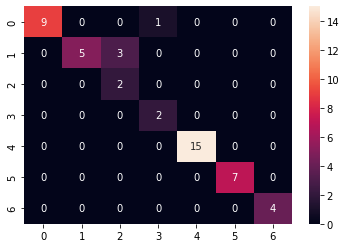

In [140]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

In [59]:
fish_dataset = pd.read_csv("../Fish.csv")
fish_dataset.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


In [60]:
X = fish_dataset.drop(["Species", "Width", "Length2", "Weight"], axis=1).to_numpy()
y = encoding_label(fish_dataset).to_numpy()

kf.get_n_splits(X)
for idx, (train_index, test_index) in enumerate(kf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    scaler = StandardScaler()
    transform = scaler.fit(X_train)
    X_train = transform.transform(X_train)
    X_test = transform.transform(X_test)
    
    freq_list = calculate_freq(y_train, classes)
    freq_list = 1/(freq_list + 0.00001)
    
    y_train = convert_to_one_hot(y_train, len(classes))
    X_train = reshape_data(X_train)
    
    w, b= train_ANN(X_train, y_train)
    test1 = reshape_data(X_test)
    y_pred = test(test1, w, b)
    print("Fold " + str(idx))
    print(classification_report(y_test, y_pred))

Epoch 1: loss = 12.428350, accuracy = 0.142848
Epoch 5001: loss = 0.410392, accuracy = 0.951659
Epoch 10001: loss = 0.043232, accuracy = 0.993869
Epoch 15001: loss = 0.016652, accuracy = 0.997502
Epoch 20001: loss = 0.009480, accuracy = 0.998530
Epoch 25001: loss = 0.006601, accuracy = 0.998990
Epoch 30001: loss = 0.004873, accuracy = 0.999244
Epoch 35001: loss = 0.003868, accuracy = 0.999404
(128, 53)
(7, 53)
(7, 53)
Fold 0
              precision    recall  f1-score   support

           0       1.00      0.75      0.86        12
           1       0.60      0.43      0.50         7
           2       0.00      0.00      0.00         2
           3       0.33      1.00      0.50         3
           4       0.85      0.58      0.69        19
           5       1.00      0.67      0.80         6
           6       0.31      1.00      0.47         4

    accuracy                           0.64        53
   macro avg       0.58      0.63      0.55        53
weighted avg       0.76      

c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Epoch 5001: loss = 1.158398, accuracy = 0.902238
Epoch 10001: loss = 0.163674, accuracy = 0.972443
Epoch 15001: loss = 0.041633, accuracy = 0.992354
Epoch 20001: loss = 0.022163, accuracy = 0.995883
Epoch 25001: loss = 0.014101, accuracy = 0.997354
Epoch 30001: loss = 0.009984, accuracy = 0.998113
Epoch 35001: loss = 0.007635, accuracy = 0.998561
(128, 53)
(7, 53)
(7, 53)
Fold 1
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       0.67      0.33      0.44         6
           2       0.00      0.00      0.00         2
           3       1.00      1.00      1.00         4
           4       0.83      1.00      0.90        19
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5

    accuracy                           0.89        53
   macro avg       0.77      0.76      0.76        53
weighted avg       0.84      0.89      0.86        53

Epoch 1: loss = 12.53

c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Epoch 5001: loss = 0.346114, accuracy = 0.943962
Epoch 10001: loss = 0.037385, accuracy = 0.993203
Epoch 15001: loss = 0.015868, accuracy = 0.997069
Epoch 20001: loss = 0.009328, accuracy = 0.998269
Epoch 25001: loss = 0.006400, accuracy = 0.998811
Epoch 30001: loss = 0.004777, accuracy = 0.999112
Epoch 35001: loss = 0.003763, accuracy = 0.999300
(128, 53)
(7, 53)
(7, 53)
Fold 2
              precision    recall  f1-score   support

           0       0.79      1.00      0.88        11
           1       1.00      0.43      0.60         7
           2       0.29      1.00      0.44         2
           3       1.00      0.25      0.40         4
           4       1.00      0.94      0.97        18
           5       1.00      1.00      1.00         6
           6       1.00      1.00      1.00         5

    accuracy                           0.85        53
   macro avg       0.87      0.80      0.76        53
weighted avg       0.93      0.85      0.85        53

